1. 符号式编程
2. 混合式编程：torchscript
3. Sequential的混合式编程
    * 通过混合式编程加速
    * 序列化
4. 小结

In [3]:
# 命令式编程
def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g

print(fancy_func(1, 2, 3, 4))

10


计算流程：
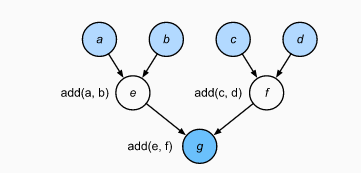

In [4]:
# 符号式编程
def add_():
    return '''
def add(a, b):
    return a + b
'''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
'''

def evoke_():
    return add_() + fancy_func_() + 'print(fancy_func(1, 2, 3, 4))'

prog = evoke_()
print(prog)
y = compile(prog, '', 'exec')
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
print(fancy_func(1, 2, 3, 4))
10


In [14]:
# 多层感知机
import torch
from torch import nn
import dltools


# 生产网络的工厂模式
def get_net():
    net = nn.Sequential(nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
    return net

x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[ 0.0461, -0.2136]], grad_fn=<AddmmBackward0>)

In [15]:
net = torch.jit.script(net)
net(x)

tensor([[ 0.0461, -0.2136]], grad_fn=<DifferentiableGraphBackward>)

In [16]:
#  通过混合式编程加速
#  时间测试方法
class Benchmark:
    """用于测量运行时间"""
    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = dltools.Timer()
        return self

    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

In [17]:
net = get_net()
with Benchmark('无torchscript'):
    for i in range(1000): net(x)

net = torch.jit.script(net)
with Benchmark('有torchscript'):
    for i in range(1000): net(x)

无torchscript: 0.2520 sec
有torchscript: 0.1780 sec


In [18]:
# 序列化模型
net.save('my_mlp')